"""
# Graph Quality Score (GQS) Formulation

This scoring function combines multiple criteria to evaluate the quality of a graph layout.
Each metric is normalized between 0 and 1, where 1 represents the best possible value.

## Criteria:
- **oo_nni**: Orthogonal Ordering preservation Normalized Number of Inversions.
  - Range: 0 <= r <= 1
  - Best when close to 1 (preserves order).
- **sp_ch_a**: Spread minimization via Convex Hull Area.
  - Range: >= 1
  - Best when close to 1 (compact spread).
- **gs_bb_iar**: Global Shape preservation via Bounding Box Improved Aspect Ratio.
  - Range: >= 1
  - Best when close to 1 (ideal aspect ratio).
- **nm_dm_imse**: Node Movement minimization via Improved Mean Squared Euclidean Distance.
  - Range: >= 0
  - Best when close to 0 (minimal node movement).
- **eb_rsdd**: Edge Length preservation via Relative Standard Deviation of Distances.
  - Range: >= 0
  - Best when close to 0 (uniform edge lengths).
- **node_overlaps**: Number of overlapping nodes.
  - Range: >= 0
  - Best when close to 0 (no overlaps).
- **area_size**: Canvas area size.
  - Range: >= 0
  - Best when small (compact layout).

## Scoring Formula:
The final Graph Quality Score (GQS) is computed as:

GQS = ( 
    w1 * oo_nni +
    w2 * (1 / (sp_ch_a + ε)) +
    w3 * (1 / (gs_bb_iar + ε)) +
    w4 * (1 / (1 + nm_dm_imse)) +
    w5 * (1 / (1 + eb_rsdd)) +
    w6 * (1 / (1 + node_overlaps)) +
    w7 * (1 / (1 + area_size))
) / (w1 + w2 + w3 + w4 + w5 + w6 + w7)

where:
- **w1 to w7** are the weights for each metric (default = 1 for all).
- **ε** is a small number (e.g., 1e-6) to avoid division by zero.

## Usage:
- Higher GQS means a better-quality graph layout.
- You can adjust weights to prioritize certain criteria (e.g., node overlaps or area compactness).
"""


In [ ]:
def compute_gqs(
    oo_nni, sp_ch_a, gs_bb_iar,
    nm_dm_imse, eb_rsdd,
    node_overlaps, area_size,
    weights=[1, 1, 1, 1, 1, 1, 1]
):
    score = (
        weights[0] * oo_nni +
        weights[1] * (1 / (sp_ch_a + 1e-6)) +  # avoid division by 0
        weights[2] * (1 / (gs_bb_iar + 1e-6)) +
        weights[3] * (1 / (1 + nm_dm_imse)) +
        weights[4] * (1 / (1 + eb_rsdd)) +
        weights[5] * (1 / (1 + node_overlaps)) +
        weights[6] * (1 / (1 + area_size))
    )
    total_weight = sum(weights)
    return score / total_weight


In [1]:
pip install scikit-optimize

                                              0.0/107.8 kB ? eta -:--:--
     -----------                             30.7/107.8 kB 1.4 MB/s eta 0:00:01
     -----------------                     51.2/107.8 kB 890.4 kB/s eta 0:00:01
     ----------------------------          81.9/107.8 kB 770.8 kB/s eta 0:00:01
     ------------------------------------ 107.8/107.8 kB 895.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 2] Le fichier spécifié est introuvable: 'c:\\Python311\\Scripts\\pyaml.exe' -> 'c:\\Python311\\Scripts\\pyaml.exe.deleteme'


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



🚀 Optimization Complete!
Best weights: [1, 5, 5, 1, 1, 1, 1, 1]
Best average score: 1.3181127327838302


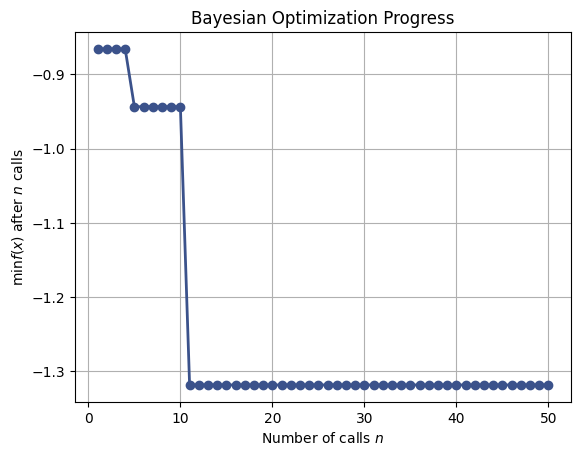

✅ Scores saved to output_scoresBYAZENoP.csv


In [2]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Integer
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

class GQSOptimizer:
    def __init__(self, graphs_metrics, weight_range=(1, 5)):
        """
        Initialize the optimizer.
        
        Args:
            graphs_metrics (list): List of dicts, each representing a graph's metrics.
            weight_range (tuple): Min and max weight value for optimization.
        """
        self.graphs_metrics = graphs_metrics
        self.weight_range = weight_range
        self.result = None
        self.best_weights = None

    def compute_gqs(self, metrics, weights):
        """
        Compute the Graph Quality Score (GQS) for a single graph.

        Args:
            metrics (dict): Metrics for a graph.
            weights (list): Current weights.

        Returns:
            float: GQS score.
        """
        score = (
            weights[0] * metrics["oo_nni"] +
            weights[1] * (1 / (metrics["sp_ch_a"] + 1e-6)) +
            weights[2] * (1 / (metrics["gs_bb_iar"] + 1e-6)) +
            weights[3] * (1 / (1 + metrics["nm_dm_imse"])) +
            weights[4] * (1 / (1 + metrics["eb_rsdd"])) +
            weights[5] * (1 / (1 + metrics["node_overlaps"])) +
            weights[6] * (1 / (1 + metrics["area_size"])) +
            weights[7] * (1 / (1 + metrics["avg_node_size"]))
        )
        return score / sum(weights)

    def objective(self, weights):
        """
        Objective function for Bayesian optimization.

        Args:
            weights (list): Current weights.

        Returns:
            float: Negative average GQS (because skopt minimizes).
        """
        scores = [
            self.compute_gqs(metrics, weights)
            for metrics in self.graphs_metrics
        ]
        avg_score = np.mean(scores)
        return -avg_score  # Minimizer needs negative

    def optimize(self, n_calls=50, n_random_starts=10, random_state=42):
        """
        Run Bayesian optimization to find the best weights.

        Args:
            n_calls (int): Total number of evaluations.
            n_random_starts (int): Random starting points.
            random_state (int): Random seed.
        """
        search_space = [
            Integer(self.weight_range[0], self.weight_range[1], name=f'w{i}')
            for i in range(8)  # Now 8 weights to include avg_node_size
        ]
        self.result = gp_minimize(
            func=self.objective,
            dimensions=search_space,
            n_calls=n_calls,
            n_random_starts=n_random_starts,
            random_state=random_state
        )
        self.best_weights = self.result.x
        print("\n🚀 Optimization Complete!")

    def get_best_weights(self):
        """
        Get the best weights found.

        Returns:
            list: Best weight vector.
        """
        if self.result is None:
            raise ValueError("You must run optimize() first!")
        return self.best_weights

    def get_best_score(self):
        """
        Get the best average GQS achieved.

        Returns:
            float: Best average score.
        """
        if self.result is None:
            raise ValueError("You must run optimize() first!")
        return -self.result.fun

    def plot_convergence(self):
        """
        Plot the optimization convergence curve.
        """
        if self.result is None:
            raise ValueError("You must run optimize() first!")
        plot_convergence(self.result)
        plt.title("Bayesian Optimization Progress")
        plt.show()

    def calculate_and_save_scores(self, input_csv, output_csv="scores_output.csv"):
        """
        Calculate scores for all entries in the input CSV and save to output CSV.
        
        Args:
            input_csv (str): Path to input CSV file.
            output_csv (str): Path to save output CSV.
        """
        if self.best_weights is None:
            raise ValueError("You must run optimize() first!")
            
        # Load input data
        df = pd.read_csv(input_csv)
        
        # Prepare results
        results = []
        for _, row in df.iterrows():
            metrics = {
                "oo_nni": row["oo_nni"],
                "sp_ch_a": row["sp_ch_a"],
                "gs_bb_iar": row["gs_bb_iar"],
                "nm_dm_imse": row["nm_dm_imse"],
                "eb_rsdd": row["eb_rsdd"],
                "node_overlaps": row["node_overlaps"],
                "area_size": row["area_size"],
                "avg_node_size": row["avg_node_size"]
            }
            
            score = self.compute_gqs(metrics, self.best_weights)
            results.append({
                "filename": row["filename"],
                "algorithm": row["algorithm"],
                "score": round(score,3)
            })
        
        # Save to CSV
        pd.DataFrame(results).to_csv(output_csv, index=False)
        print(f"✅ Scores saved to {output_csv}")


# Example usage:
if __name__ == "__main__":
    # Load your metrics data (replace with your actual data loading code)
    # This would typically come from processing your CSV and JSON files
    example_metrics = [
        {
            "oo_nni": 0.8, "sp_ch_a": 0.5, "gs_bb_iar": 0.6,
            "nm_dm_imse": 0.2, "eb_rsdd": 0.3,
            "node_overlaps": 2, "area_size": 1000, "avg_node_size": 50
        },
        # Add more metrics as needed
    ]
    
    # Initialize and run optimizer
    optimizer = GQSOptimizer(example_metrics)
    optimizer.optimize()
    
    print("Best weights:", optimizer.get_best_weights())
    print("Best average score:", optimizer.get_best_score())
    optimizer.plot_convergence()
    
    # Calculate and save scores for your CSV file
    optimizer.calculate_and_save_scores("processed_metrics2.csv", "output_scoresBYAZENoP.csv")

In [ ]:
# ---------------- Prepare Your Graph Metrics ---------------- #
graphs_metrics = [
    {"oo_nni": 0.9, "sp_ch_a": 1.1, "gs_bb_iar": 1.2, "nm_dm_imse": 0.05, "eb_rsdd": 0.1, "node_overlaps": 2, "area_size": 5000},
    {"oo_nni": 0.8, "sp_ch_a": 1.05, "gs_bb_iar": 1.15, "nm_dm_imse": 0.1, "eb_rsdd": 0.2, "node_overlaps": 1, "area_size": 4500},
    # More graphs...
]

# ---------------- Use the Optimizer ---------------- #
optimizer = GQSOptimizer(graphs_metrics, weight_range=(1, 5))
optimizer.optimize(n_calls=50)

print("\n🥇 Best Weights:", optimizer.best_weights())
print(f"🏆 Best Average GQS: {optimizer.best_score():.4f}")

# Optional: Plot convergence curve
optimizer.plot_convergence()


In [ ]:
#Hyperparameter tuning for n_calls,noeud sizes

import numpy as np
from skopt import gp_minimize
from skopt.space import Integer
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, RBF, RationalQuadratic
import warnings

warnings.filterwarnings("ignore")

class GQSOptimizer:
    def __init__(self, graphs_metrics, weight_range=(1, 5)):
        """
        Initialize the optimizer.

        Args:
            graphs_metrics (list): List of dicts, each graph's metrics.
            weight_range (tuple): (min, max) weight values.
        """
        self.graphs_metrics = graphs_metrics
        self.weight_range = weight_range
        self.result = None

    def compute_gqs(self, metrics, weights):
        """
        Compute Graph Quality Score (GQS) for one graph.

        Metrics must contain:
        - oo_nni, sp_ch_a, gs_bb_iar, nm_dm_imse, eb_rsdd, node_overlaps, area_size, avg_node_size
        """
        score = (
            weights[0] * metrics["oo_nni"] +
            weights[1] * (1 / (metrics["sp_ch_a"] + 1e-6)) +
            weights[2] * (1 / (metrics["gs_bb_iar"] + 1e-6)) +
            weights[3] * (1 / (1 + metrics["nm_dm_imse"])) +
            weights[4] * (1 / (1 + metrics["eb_rsdd"])) +
            weights[5] * (1 / (1 + metrics["node_overlaps"])) +
            weights[6] * (1 / (1 + metrics["area_size"])) +
            weights[7] * (1 / (1 + metrics["avg_node_size"]))  # new!
        )
        return score / sum(weights)

    def objective(self, weights):
        """
        Objective for Bayesian Optimization: negative average GQS.
        """
        scores = [
            self.compute_gqs(metrics, weights)
            for metrics in self.graphs_metrics
        ]
        avg_score = np.mean(scores)
        return -avg_score

    def optimize(self, n_calls=50, n_random_starts=10, random_state=42, kernel_choice="Matern"):
        """
        Run Bayesian optimization with custom hyperparameters.

        Args:
            n_calls (int): Total optimization steps.
            n_random_starts (int): Random starting points.
            random_state (int): Random seed.
            kernel_choice (str): 'Matern', 'RBF', or 'RQ' (Rational Quadratic).
        """
        # Choose Kernel
        if kernel_choice == "Matern":
            kernel = Matern()
        elif kernel_choice == "RBF":
            kernel = RBF()
        elif kernel_choice == "RQ":
            kernel = RationalQuadratic()
        else:
            raise ValueError("kernel_choice must be 'Matern', 'RBF', or 'RQ'")

        search_space = [
            Integer(self.weight_range[0], self.weight_range[1], name=f'w{i}')
            for i in range(8)  # 8 metrics now
        ]

        self.result = gp_minimize(
            func=self.objective,
            dimensions=search_space,
            n_calls=n_calls,
            n_random_starts=n_random_starts,
            base_estimator=GaussianProcessRegressor(kernel=kernel),
            random_state=random_state
        )
        print("\n🚀 Optimization Complete!")

    def best_weights(self):
        if self.result is None:
            raise ValueError("You must run optimize() first!")
        return self.result.x

    def best_score(self):
        if self.result is None:
            raise ValueError("You must run optimize() first!")
        return -self.result.fun

    def plot_convergence(self):
        if self.result is None:
            raise ValueError("You must run optimize() first!")
        plot_convergence(self.result)
        plt.title("Bayesian Optimization Progress")
        plt.show()


In [ ]:
# Example graphs with avg_node_size
graphs_metrics = [
    {"oo_nni": 0.9, "sp_ch_a": 1.1, "gs_bb_iar": 1.2, "nm_dm_imse": 0.05, "eb_rsdd": 0.1, "node_overlaps": 2, "area_size": 5000, "avg_node_size": 15},
    {"oo_nni": 0.85, "sp_ch_a": 1.0, "gs_bb_iar": 1.1, "nm_dm_imse": 0.08, "eb_rsdd": 0.15, "node_overlaps": 1, "area_size": 4800, "avg_node_size": 12},
    # Add more
]

optimizer = GQSOptimizer(graphs_metrics, weight_range=(1, 5))

# Run Bayesian Optimization
optimizer.optimize(
    n_calls=70,               # More calls = better search
    n_random_starts=15,        # Start randomly before learning
    kernel_choice="Matern"     # Matern kernel (good general choice)
)

print("\n🥇 Best Weights:", optimizer.best_weights())
print(f"🏆 Best Average GQS: {optimizer.best_score():.4f}")

optimizer.plot_convergence()


In [ ]:
#A version that evaluates several kernels and picks the best kernel automatically? 🔥

In [4]:
pip install scikit-optimize

  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Integer
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, RBF, RationalQuadratic
import warnings

warnings.filterwarnings("ignore")

class GQSOptimizer:
    def __init__(self, graphs_metrics, weight_range=(1, 5)):
        """
        Initialize the optimizer.

        Args:
            graphs_metrics (list): List of dicts, each graph's metrics.
            weight_range (tuple): (min, max) weight values.
        """
        self.graphs_metrics = graphs_metrics
        self.weight_range = weight_range
        self.results = {}  # Store results per kernel
        self.best_kernel = None
        self.best_result = None

    def compute_gqs(self, metrics, weights):
        """
        Compute Graph Quality Score (GQS) for one graph.
        """
        score = (
            weights[0] * metrics["oo_nni"] +
            weights[1] * (1 / (metrics["sp_ch_a"] + 1e-6)) +
            weights[2] * (1 / (metrics["gs_bb_iar"] + 1e-6)) +
            weights[3] * (1 / (1 + metrics["nm_dm_imse"])) +
            weights[4] * (1 / (1 + metrics["eb_rsdd"])) +
            weights[5] * (1 / (1 + metrics["node_overlaps"])) +
            weights[6] * (1 / (1 + metrics["area_size"])) +
            weights[7] * (1 / (1 + metrics["avg_node_size"]))
        )
        return score / sum(weights)

    def objective(self, weights):
        """
        Objective function for optimization.
        """
        scores = [
            self.compute_gqs(metrics, weights)
            for metrics in self.graphs_metrics
        ]
        avg_score = np.mean(scores)
        return -avg_score

    def optimize_kernel(self, kernel_name, n_calls, n_random_starts, random_state):
        """
        Optimize with a given kernel.
        """
        if kernel_name == "Matern":
            kernel = Matern()
        elif kernel_name == "RBF":
            kernel = RBF()
        elif kernel_name == "RQ":
            kernel = RationalQuadratic()
        else:
            raise ValueError("kernel_choice must be 'Matern', 'RBF', or 'RQ'")

        search_space = [
            Integer(self.weight_range[0], self.weight_range[1], name=f'w{i}')
            for i in range(8)
        ]

        result = gp_minimize(
            func=self.objective,
            dimensions=search_space,
            n_calls=n_calls,
            n_random_starts=n_random_starts,
            base_estimator=GaussianProcessRegressor(kernel=kernel),
            random_state=random_state
        )

        return result

    def optimize(self, n_calls=50, n_random_starts=10, random_state=42):
        """
        Try multiple kernels and pick the best one automatically.
        """
        kernels = ["Matern", "RBF", "RQ"]
        best_score = -np.inf

        for kernel_name in kernels:
            print(f"🔍 Optimizing with kernel: {kernel_name} ...")
            result = self.optimize_kernel(kernel_name, n_calls, n_random_starts, random_state)
            final_score = -result.fun  # Reverse because minimization
            self.results[kernel_name] = result

            if final_score > best_score:
                best_score = final_score
                self.best_kernel = kernel_name
                self.best_result = result

        print(f"\n🚀 Best Kernel Selected: {self.best_kernel}")
        print(f"🏆 Best Average GQS: {best_score:.4f}")

    def best_weights(self):
        if self.best_result is None:
            raise ValueError("You must run optimize() first!")
        return self.best_result.x

    def best_score(self):
        if self.best_result is None:
            raise ValueError("You must run optimize() first!")
        return -self.best_result.fun

    def plot_convergence(self):
        if self.best_result is None:
            raise ValueError("You must run optimize() first!")
        plot_convergence(self.best_result)
        plt.title(f"Bayesian Optimization Progress ({self.best_kernel})")
        plt.show()


🔍 Optimizing with kernel: Matern ...
🔍 Optimizing with kernel: RBF ...
🔍 Optimizing with kernel: RQ ...

🚀 Best Kernel Selected: Matern
🏆 Best Average GQS: 0.8262

🥇 Best Weights: [5, 5, 5, 5, 5, 1, 1, 1]
🏆 Best Average GQS: 0.8262


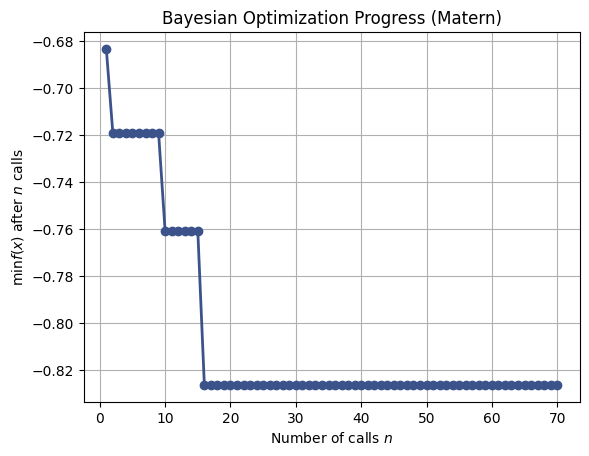

In [6]:
# Example graph metrics including avg_node_size
graphs_metrics = [
    {"oo_nni": 0.9, "sp_ch_a": 1.1, "gs_bb_iar": 1.2, "nm_dm_imse": 0.05, "eb_rsdd": 0.1, "node_overlaps": 2, "area_size": 5000, "avg_node_size": 15},
    {"oo_nni": 0.85, "sp_ch_a": 1.0, "gs_bb_iar": 1.1, "nm_dm_imse": 0.08, "eb_rsdd": 0.15, "node_overlaps": 1, "area_size": 4800, "avg_node_size": 12},
    # Add more graphs here...
]

# Initialize and optimize
optimizer = GQSOptimizer(graphs_metrics, weight_range=(1, 5))
optimizer.optimize(
    n_calls=70,
    n_random_starts=15
)

print("\n🥇 Best Weights:", optimizer.best_weights())
print(f"🏆 Best Average GQS: {optimizer.best_score():.4f}")

# Optional: Plot convergence for the best kernel
optimizer.plot_convergence()


🔍 Optimizing with kernel: Matern ...
🔍 Optimizing with kernel: RBF ...
🔍 Optimizing with kernel: RQ ...

🚀 Best Kernel Selected: Matern
🏆 Best Average GQS: 0.8840

🥇 Best Weights: [1, 1, 5, 1, 1, 5, 5, 5]
🏆 Best Average GQS: 0.8840


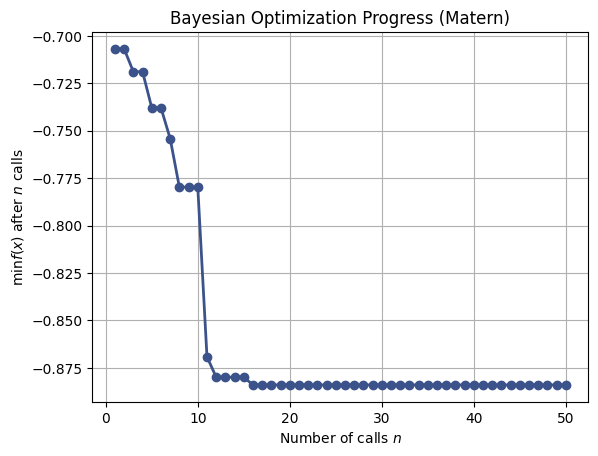

In [9]:
import pandas as pd
# Adjust import as needed

# Load your CSV file
df = pd.read_csv("Data/Fati/synthetic/synthetic/generated-evaluation.csv", sep=";")  # Use actual filename

# Prepare graph metric dictionaries
metrics_list = []
for _, row in df.iterrows():
    metrics = {
        "oo_nni": row["oo_nni"],
        "sp_ch_a": row["sp_ch_a"],
        "gs_bb_iar": row["gs_bb_iar"],
        "nm_dm_imse": row["nm_dm_imse"],
        "eb_rsdd": row["eb_rsdd"],
        "node_overlaps": row.get("node_overlaps", 0),
        "area_size": row.get("area_size", 0),
        "avg_node_size": row.get("avg_node_size", 0),
    }
    metrics_list.append(metrics)

# Create and run the optimizer
optimizer = GQSOptimizer(metrics_list, weight_range=(1, 5))
optimizer.optimize()

print("\n🥇 Best Weights:", optimizer.best_weights())
print(f"🏆 Best Average GQS: {optimizer.best_score():.4f}")
optimizer.plot_convergence()


In [11]:
import pandas as pd
 # Replace with actual file/module name

# Load CSV
df = pd.read_csv("Data/Fati/synthetic/synthetic/generated-evaluation.csv", sep=";")

# Combine type, n, iteration into a filename
df["filename"] = df["type"].astype(str) + "_" + df["n"].astype(str) + "_" + df["iteration"].astype(str)

# Prepare graph metrics for optimization
metrics_list = []
for _, row in df.iterrows():
    metrics = {
        "oo_nni": row["oo_nni"],
        "sp_ch_a": row["sp_ch_a"],
        "gs_bb_iar": row["gs_bb_iar"],
        "nm_dm_imse": row["nm_dm_imse"],
        "eb_rsdd": row["eb_rsdd"],
        "node_overlaps": row.get("node_overlaps", 0),
        "area_size": row.get("area_size", 0),
        "avg_node_size": row.get("avg_node_size", 0),
    }
    metrics_list.append(metrics)

# Optimize weights
optimizer = GQSOptimizer(metrics_list, weight_range=(1, 5))
optimizer.optimize()
best_weights = optimizer.best_weights()

# Compute individual scores per graph
gqs_scores = []
for i, row in df.iterrows():
    metrics = {
        "oo_nni": row["oo_nni"],
        "sp_ch_a": row["sp_ch_a"],
        "gs_bb_iar": row["gs_bb_iar"],
        "nm_dm_imse": row["nm_dm_imse"],
        "eb_rsdd": row["eb_rsdd"],
        "node_overlaps": row.get("node_overlaps", 0),
        "area_size": row.get("area_size", 0),
        "avg_node_size": row.get("avg_node_size", 0),
    }
    score = optimizer.compute_gqs(metrics, best_weights)
    gqs_scores.append({
        "filename": row["filename"],
        "algorithm": row["algorithm"],
        "GQS": round(score, 3)
    })

# Convert to DataFrame and export
results_df = pd.DataFrame(gqs_scores)
print(results_df.head())

# Optionally save to CSV
results_df.to_csv("gqs_scores_per_algorithm.csv", index=False)


🔍 Optimizing with kernel: Matern ...
🔍 Optimizing with kernel: RBF ...
🔍 Optimizing with kernel: RQ ...

🚀 Best Kernel Selected: Matern
🏆 Best Average GQS: 0.8840
     filename algorithm    GQS
0  pa_1000_10     gtree  0.855
1  pa_1000_10       pfs  0.782
2  pa_1000_10      pfsp  0.861
3  pa_1000_10     prism  0.824
4  pa_1000_10   rwordle  0.842
